In [1]:
import numpy as np

flat_length = 0.8 # Desired bottom flat surface
tapering_ratio = 0.6
root_chord = 0.3 
washout_angle = 2 # degrees
start_angle = 1 # Neutral starting angle
sweep_angle =30 # degrees
speed = 20 # Cruise speed m/s
alpha = 2.5 # degrees of attack of the all  from neutral, None for neutral


Estimated reynolds 378846.1538, estimated neutral angle 1.1111
Optimization test 1/1 with initial guess: [0.0609769  0.06515855 0.28212398 0.23543014 0.00657257 0.07852994]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -245.25928312638558
            Iterations: 17
            Function evaluations: 131
            Gradient evaluations: 17
Estimated reynolds 361538.4615, estimated neutral angle 1.4444
Optimization test 1/1 with initial guess: [0.227393   0.13201523 0.09046594 0.25397057 0.03382233 0.17899817]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -245.7310136514603
            Iterations: 18
            Function evaluations: 143
            Gradient evaluations: 18
Estimated reynolds 326923.0769, estimated neutral angle 2.1111
Optimization test 1/1 with initial guess: [0.29285193 0.17896148 0.16740183 0.18131811 0.27774626 0.25111796]
Optimization terminated successfully    (Exit mode 0)
    

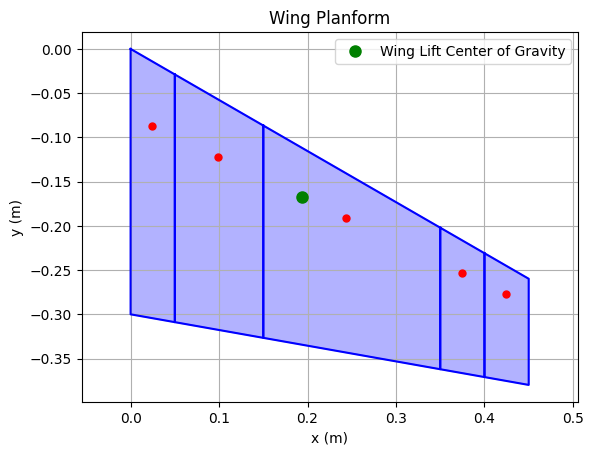

Wing Lift Center of Gravity at x: 0.194 m, y: -0.168 m


In [2]:
from utils.optimize import lift_data, converence_contrain

profiles = []
x_roots = np.array([0, 0.05, 0.15, 0.35, 0.4, 0.45]) # Last root is the tip end

for j in range(len(x_roots) - 1):

    # Forme moyenne parfaite
    l0 = root_chord * (1 - tapering_ratio * x_roots[j]) # Estimate reynolds
    l1 = root_chord * (1 - tapering_ratio * x_roots[j + 1]) # Estimate reynolds

    reynolds_estimated = speed * (l0 + l1) / (2 * 1.56e-5)

    angle_estimated = (x_roots[j] + x_roots[j+1])/(2 * x_roots[-1]) * (washout_angle) + start_angle

    print(f"Estimated reynolds {reynolds_estimated:.4f}, estimated neutral angle {angle_estimated:.4f}")

    shape = converence_contrain(
        angle_estimated,
        flat_length,
        reynolds_estimated,
        1,
    )

    profile = {
        'params': shape,
        "x_root": x_roots[j],
    }
    profiles.append(profile)

main_data, (cg_x, cg_y) = lift_data(root_chord, x_roots[-1], sweep_angle, tapering_ratio, profiles, speed, alpha=start_angle, plot_wing=True)

print(f"Wing Lift Center of Gravity at x: {cg_x:.3f} m, y: {cg_y:.3f} m")

In [3]:
total_lift = 0
total_drag = 0
for section in main_data:
    total_lift += section['lift']
    total_drag += section['drag']

print("\nOverall Aerodynamic Forces for a single wing:")
print(f"Total Lift: {round(total_lift, 3)} N ({round(total_lift/9.81, 3)} kg) for speed {speed} m/s")
print(f"Total Drag: {round(total_drag, 3)} N for speed {speed} m/s")


Overall Aerodynamic Forces for a single wing:
Total Lift: 21.603 N (2.202 kg) for speed 20 m/s
Total Drag: 0.243 N for speed 20 m/s


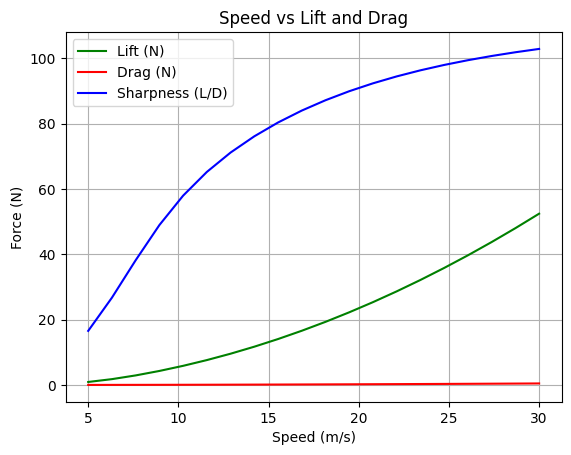

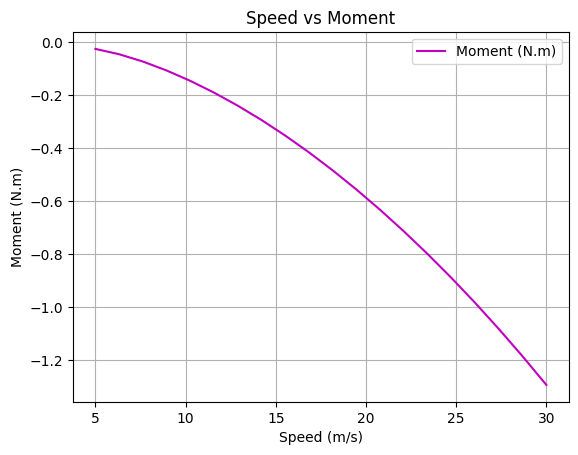

In [4]:
# Plot speed to lift and drag curves
import matplotlib.pyplot as plt


speeds = np.linspace(5, 30, 20)
lifts = []
drags = []
sharpness = []
momentum = []
for spd in speeds:
    data, _ = lift_data(root_chord, x_roots[-1], sweep_angle, tapering_ratio, profiles, spd, alpha=alpha, plot_wing=False)
    lift = sum([section['lift'] for section in data])
    drag = sum([section['drag'] for section in data])
    moment = sum([section['moment'] for section in data])
    sharpness.append(lift/drag if drag != 0 else 0)  
    lifts.append(lift)
    drags.append(drag)
    momentum.append(moment)

plt.plot(speeds, lifts, 'g-', label='Lift (N)')
plt.plot(speeds, drags, 'r-', label='Drag (N)')
plt.plot(speeds, sharpness, 'b-', label='Sharpness (L/D)')
plt.xlabel('Speed (m/s)')
plt.ylabel('Force (N)')
plt.title('Speed vs Lift and Drag')
plt.legend()
plt.grid(True)
plt.show()

# Plot speed to moment curve
plt.plot(speeds, momentum, 'm-', label='Moment (N.m)')
plt.xlabel('Speed (m/s)')   
plt.ylabel('Moment (N.m)')
plt.title('Speed vs Moment')
plt.legend()
plt.grid(True)
plt.show()


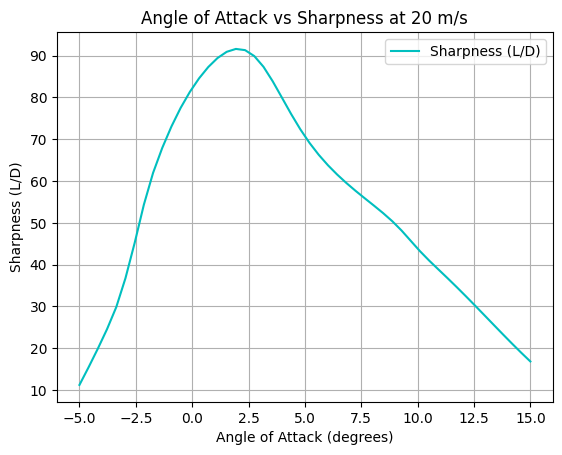

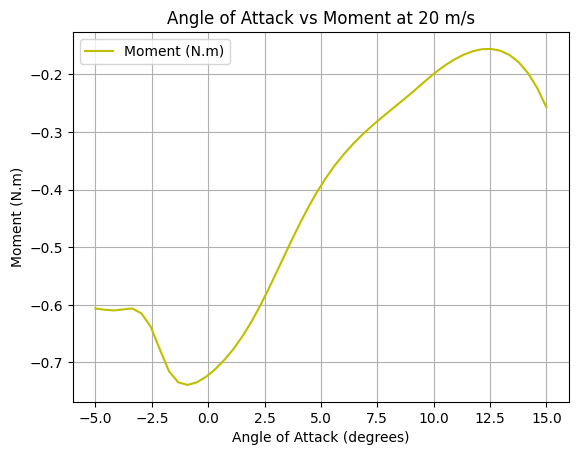

In [5]:
# Sharpness and momentum depending on alpha
cruise_speed = speed
alphas = np.linspace(-5, 15, 50)
sharpness_alpha = []
momentum_alpha = []

for alpha_angle in alphas:
    data, _ = lift_data(root_chord, x_roots[-1], sweep_angle, tapering_ratio, profiles, cruise_speed, alpha=alpha_angle, plot_wing=False)
    lift = sum([section['lift'] for section in data])
    drag = sum([section['drag'] for section in data])
    moment = sum([section['moment'] for section in data])
    sharpness_alpha.append(lift/drag if drag != 0 else 0)  
    momentum_alpha.append(moment)

plt.plot(alphas, sharpness_alpha, 'c-', label='Sharpness (L/D)')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Sharpness (L/D)')
plt.title(f'Angle of Attack vs Sharpness at {cruise_speed} m/s')
plt.legend()
plt.grid(True)  
plt.show()

plt.plot(alphas, momentum_alpha, 'y-', label='Moment (N.m)')
plt.xlabel('Angle of Attack (degrees)')   
plt.ylabel('Moment (N.m)')
plt.title(f'Angle of Attack vs Moment at {cruise_speed} m/s')
plt.legend()
plt.grid(True)

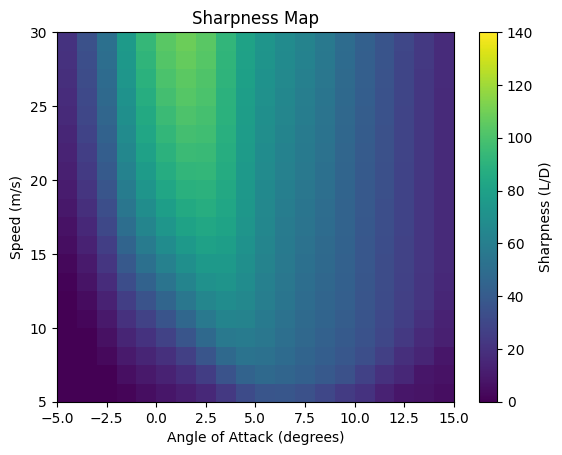

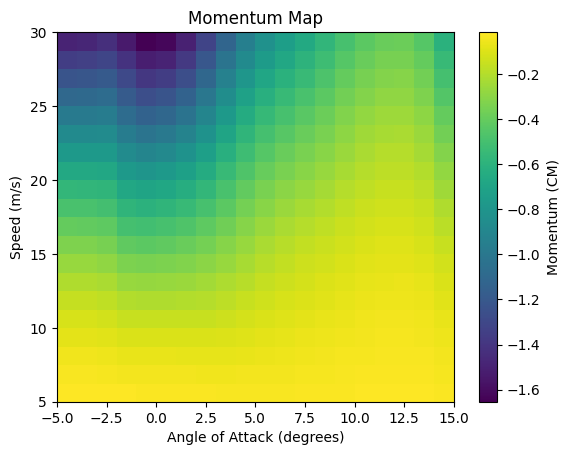

In [6]:

speeds = np.linspace(5, 30, 20)
alphas = np.linspace(-5, 15, 20)

sharpness_map = np.zeros((len(speeds), len(alphas)))
momentum_map = np.zeros((len(speeds), len(alphas)))

for i, spd in enumerate(speeds):
    for j, alpha_angle in enumerate(alphas):
        data, _ = lift_data(root_chord, x_roots[-1], sweep_angle, tapering_ratio, profiles, spd, alpha=alpha_angle, plot_wing=False)
        lift = sum([section['lift'] for section in data])
        drag = sum([section['drag'] for section in data])
        moment = sum([section['moment'] for section in data])
        sharpness_map[i, j] = lift/drag if drag != 0 else 0  
        momentum_map[i, j] = moment

plt.imshow(sharpness_map, extent=(alphas[0], alphas[-1], speeds[0], speeds[-1]), aspect='auto', origin='lower', cmap='viridis', vmin=0, 
           vmax=140)
plt.colorbar(label='Sharpness (L/D)')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Speed (m/s)')
plt.title('Sharpness Map')
plt.show()

plt.imshow(momentum_map, extent=(alphas[0], alphas[-1], speeds[0], speeds[-1]), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Momentum (CM)')
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel('Speed (m/s)')
plt.title('Momentum Map')
plt.show()